In [1]:
# -*- coding: utf-8 -*-

# Importation des librairies nécessaires

import numpy as np
import matplotlib.pyplot as plt
import random

# Pour le traitement des données
import torch 
import h5py # pour gérer les formats de données utilisés ici 
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix

#Pour l'évaluation des modèles
#import torchmetrics
#from torchmetrics.classification import Accuracy
import seaborn as sns


In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
device = 'cpu'

# TP3: Reconnaissance de signaux de communication par apprentissage profond 

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb 

2 séances de TP sur ce sujet : le 6 novembre (1h00), le 13 novembre (3h). 
Le cours du 19 novembre sera partagé en 3 : cours sur la séparation de sources audio / présentation des mini projets et organisation des soutenances / fin de ce TP.<br> 
Deadline pour le rendu du TP: 26 novembre 2024, 13h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

**Auteurs:** Constantin Vaillant Tenzer et Samuel Sarfati.

## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur 
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie 
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié. 

L'émetteur peut provenir de 6 catégories différentes. 
Les paramètres différenciant les différentes catégories sont 
- le type de modulation 
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données 
- le débit de la transmission 

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0. 


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation 
électromagnétique comme : 
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données). 
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont: 

1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html. 
3. Qualifier les performances de votre réseau de neurones sur l'ensemble de test via: 
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR 
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
4. Rapporter les performances de vos architectures à leur complexité, la complexité d'un réseau de neurones étant ici résumé au nombre de paramètres libres qu'il fait intervenir

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation. 


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet. 
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones". 

Surtout privilégiez dans un premier temps la simplicité quitte à complexifier votre approche ensuite pour doper ses performances. Ne restez pas bloqué sur des réseaux qui "mettent trop de temps à apprendre"

## Chargement des données en numpy

Le TP est composé de trois jeux de données : 
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones 
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage 
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

Sample pour le wifi. Validation optionnel. Cela ne sert à rien d'être intelligent sur les données.

In [3]:
data_path = 'train.hdf5'

data = h5py.File(data_path, 'r')

signals = np.array(data['signaux'])
snr = np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [4]:
def get_labels(open_h5_file): 
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

### Visualisation des données 

Commencez par étudier les données: 

    - observez leur taille 
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement 
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez 

Remarque : dans ce TP il n'y a pas beaucoup à gagner à faire du feature engineering 

In [36]:
data_array = np.array(data)
print(len(signals))
print(len(snr))
print(len(labels_id))

30000
30000
30000


In [37]:
print(signals)
print(np.average(signals))
print(np.min(signals))
print(np.max(signals))

[[[-1.6314461   0.10213946]
  [-1.8610548   1.0587581 ]
  [-1.3227473  -0.3087512 ]
  ...
  [ 2.5524678  -1.1176909 ]
  [-2.144728   -0.14183743]
  [ 1.5685402   1.4364138 ]]

 [[ 2.2401392   0.3780224 ]
  [-0.8386898   0.41933286]
  [-0.31032094 -0.25639293]
  ...
  [-0.06527975 -2.5865684 ]
  [-1.4600252  -1.2727835 ]
  [ 0.3735278  -0.942739  ]]

 [[ 0.7964652   0.3639845 ]
  [-0.17897135  0.5694222 ]
  [-0.384163    0.90277517]
  ...
  [ 0.6548506  -0.40047857]
  [ 0.5892955  -0.43906537]
  [ 0.12116134 -0.32299644]]

 ...

 [[-2.515238   -0.08754388]
  [-1.0148655  -0.28562468]
  [-0.42127475  2.0521984 ]
  ...
  [ 0.22316395 -2.762959  ]
  [ 0.23331423 -0.07616359]
  [-0.09802152 -1.241122  ]]

 [[ 1.6766893   0.99218315]
  [ 0.6713277   0.8992305 ]
  [-2.2675726   1.1803068 ]
  ...
  [-0.23502544  0.63387656]
  [-0.767505   -0.58275646]
  [ 1.7550484  -1.5197784 ]]

 [[ 0.7512635   0.29957932]
  [ 0.5410202  -1.8889133 ]
  [ 0.14981823  1.7470977 ]
  ...
  [ 0.4695632   0.029245

In [38]:
print(snr)
print(np.min(snr))
print(np.max(snr))
print(np.average(snr))

[ 0  0 30 ...  0  0  0]
0
30
14.906666666666666


In [39]:
print(labels_id)
print(np.max(labels_id))
print(np.min(labels_id))
print(np.average(labels_id))

[4 3 3 ... 3 2 0]
5
0
2.4875333333333334


## Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch. 
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets : 
    - un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
    - un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones 
    
Un dataset prend la forme 
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici 

In [5]:
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        self.data = h5py.File(path_to_data, 'r')
        self.labels = get_labels(self.data)
        self.signals = np.array(self.data['signaux'])
        self.snr = np.array(self.data['snr'])
        self.labels_id = np.array(self.data['labels'])
        self.data.close()

    def __len__(self): #retourne le nombre de données dans le dataset
        return len(self.signals)
        
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        return self.signals[i], self.labels_id[i]

Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [6]:
dataset = MyDataset(data_path)

Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset. 
La cellule suivante donne un exemple d'utilisation

In [7]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, 
                        batch_size=10, 
                        shuffle=True
                       )

for i, (data, label) in enumerate(dataloader):
    print(i, data, label)
    if i > 5:
        break

0 tensor([[[ 0.2849,  0.9551],
         [-0.7535,  0.0666],
         [-1.0037, -0.0456],
         ...,
         [-0.2752, -0.9614],
         [-0.1277, -0.8654],
         [ 0.5749,  0.4184]],

        [[ 0.0480,  0.2644],
         [-0.4425, -0.1554],
         [-0.0259, -1.0393],
         ...,
         [ 1.1200, -0.1715],
         [ 0.0413,  0.0246],
         [ 0.1713, -0.8147]],

        [[ 0.1744, -0.6950],
         [ 0.4131, -0.3269],
         [ 0.9952,  0.3474],
         ...,
         [-0.2165, -1.2571],
         [-0.8015, -0.7856],
         [-1.0193, -0.4159]],

        ...,

        [[-1.1530,  0.1604],
         [ 0.0050,  0.4521],
         [ 1.1538, -0.1403],
         ...,
         [-1.4010, -0.0044],
         [-1.1179, -0.0547],
         [ 0.1600,  0.1912]],

        [[ 0.0588,  0.6426],
         [ 3.0415,  0.5570],
         [ 0.8076,  0.8171],
         ...,
         [ 0.9875,  0.6054],
         [-0.3153,  0.9097],
         [ 0.4811,  0.9554]],

        [[ 0.9436,  0.2461],
     

Testez le dataloader pour différentes valeurs de batch_size 

In [43]:
for batch_size in [1, 10, 100, 1000]:
    dataloader = DataLoader(dataset, 
                            batch_size=batch_size, 
                            shuffle=True
                           )
    for i, (data, label) in enumerate(dataloader):
        print(i, data, label)
        if i > 5:
            break

0 tensor([[[ 0.4213,  1.2047],
         [ 0.0876, -0.3254],
         [ 1.0076, -0.7709],
         ...,
         [ 0.3809, -0.8752],
         [-0.1684, -0.2025],
         [-0.7176, -0.4683]]]) tensor([3], dtype=torch.int8)
1 tensor([[[-0.3563,  1.4087],
         [-0.5094,  0.4500],
         [-0.3574,  0.0793],
         ...,
         [ 1.4270,  0.3559],
         [ 0.4706,  0.2921],
         [-1.1751, -0.2680]]]) tensor([4], dtype=torch.int8)
2 tensor([[[ 0.1954,  0.5734],
         [-0.3480,  0.5484],
         [-0.3361,  0.6741],
         ...,
         [-0.0677, -0.8702],
         [ 0.0847, -0.7226],
         [-0.6338,  0.1501]]]) tensor([5], dtype=torch.int8)
3 tensor([[[-0.0519, -0.5175],
         [-0.2699,  0.2059],
         [-0.2818,  0.2214],
         ...,
         [-1.1944,  1.2530],
         [-0.6312,  0.5432],
         [-0.3288, -0.7254]]]) tensor([3], dtype=torch.int8)
4 tensor([[[ 0.0302,  0.5931],
         [ 0.2073, -0.6980],
         [-0.0120, -1.0988],
         ...,
         

Les dataloaders se chargent bien !

## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier). 

Ce modèle doit comporter moins de 10000 paramètres libres. 

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

In [8]:
class MonModeleQuiTorche(torch.nn.Module):
    def __init__(self,delta_chan=4,verbose=False):
        if verbose:
            self.print = print
        else:
            self.print = lambda x:None
        self.print('Initialisation classe mère \n')
        torch.nn.Module.__init__(self) 
        
        self.print('\n Initialisation classe courante \n')
        self.delta_chan=delta_chan
        self.learnable_param = torch.nn.Parameter(torch.rand([1,delta_chan,1]))
        self.not_learnable_param = torch.rand((1,delta_chan,1))

    def __setattr__(self,name,value):
        super().__setattr__(name,value)
        self.print(f'Enregistrement de: {name} à la valeur {value}')
        
    def forward(self,x): 
        #x is [B,input_chan,T]
        # output is [B,self.output_chan,T]
        x_reduced = torch.mean(x , axis = 1 , keepdim=True)
        x_duplicated = torch.tile(x_reduced , dims = (1, self.delta_chan, 1))

        y0 = self.learnable_param *x_duplicated 
        y1 = y0+ self.not_learnable_param

        y2 = torch.abs(y1)
        
        y3 = torch.concat([x, y2], axis=1)
        return y3
    
    def __call__(self,x):
    # Défini dans la classe mère
        return self.forward(x)

In [9]:
mon_modele = MonModeleQuiTorche(delta_chan=4,verbose=True)

Enregistrement de: print à la valeur <built-in function print>
Initialisation classe mère 


 Initialisation classe courante 

Enregistrement de: delta_chan à la valeur 4
Enregistrement de: learnable_param à la valeur Parameter containing:
tensor([[[0.3291],
         [0.8804],
         [0.1941],
         [0.7080]]], requires_grad=True)
Enregistrement de: not_learnable_param à la valeur tensor([[[0.3922],
         [0.1076],
         [0.0457],
         [0.1452]]])


Instanciez votre modèle et testez la consistence de ses entrées / sorties vis à vis des données étudiées (test purement fonctionnel, pas besoin de chercher à réaliser un entraînement à ce point).

In [10]:
# Define input_channels
input_channels = 2  # Number of channels in the input signal

# Create a dummy input tensor with the same shape as the data
dummy_input = torch.randn(10, input_channels, signals.shape[1])

# Test the consistency of MonModeleQuiTorche
mon_modele = MonModeleQuiTorche(delta_chan=4, verbose=True)
mon_modele.eval()  # Set the model to evaluation mode

# Pass the dummy input through the model
mon_modele_output = mon_modele(dummy_input)
print("MonModeleQuiTorche output shape:", mon_modele_output.shape)

Enregistrement de: print à la valeur <built-in function print>
Initialisation classe mère 


 Initialisation classe courante 

Enregistrement de: delta_chan à la valeur 4
Enregistrement de: learnable_param à la valeur Parameter containing:
tensor([[[0.2236],
         [0.4441],
         [0.2420],
         [0.6760]]], requires_grad=True)
Enregistrement de: not_learnable_param à la valeur tensor([[[0.1210],
         [0.4866],
         [0.1440],
         [0.1783]]])
Enregistrement de: training à la valeur False
MonModeleQuiTorche output shape: torch.Size([10, 6, 2048])


Estimez par un calcul "théorique" le nombre de paramètres du modèle que vous avez défini et vérifié que le modèle a bien ce nombre de paramètres en pratique par exemple en utilisant la fonction suivante : 

In [11]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

In [12]:
print("MonModeleQuiTorche nombre de paramètres:", count_n_param(mon_modele))

MonModeleQuiTorche nombre de paramètres: 4


## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à 
- charger les données 
- les batcher 
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires 

Un cavnevas d'implémentation pourrait être:

```python
device = 'cpu' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU 

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement 

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard. 

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs. 

In [17]:
model0 = MonModeleQuiTorche(delta_chan=4, verbose=True) 
 # vous instanciez ici votre modèle

loss = nn.NLLLoss()
     # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model0.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = 10 # le nombre d'itérations dans l'entrainement 

chemin_vers_sauvegarde_model0= 'model0.pth'
# chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard. 

model0.to(device) # on place le modèle dans le GPU si nécessaire

model = model0
model.to(device)

dataset = MyDataset(data_path)

dataloader_train = DataLoader(dataset,
                                batch_size=32,
                                shuffle=True
                                 )

def evaluate_loss(loss, batch_y, batch_y_predicted):
    l = loss(batch_y_predicted, batch_y)
    return l

model.train()

for epoch in range(n_epochs):

    epoch_loss = 0
    train_losses = []
    
    for batch_x, batch_y in dataloader_train:
        
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device).long()
        
        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)
        
        # Ensure the predicted tensor has the same shape as the target tensor
        if batch_y_predicted.shape != batch_y.shape:
            batch_y_predicted = batch_y_predicted.view(batch_y.size(0), -1)
        
        l = evaluate_loss(loss, batch_y, batch_y_predicted)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
    epoch_loss += l.item()

    avg_epoch_loss = epoch_loss / len(dataloader_train)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_epoch_loss:.4f}')

torch.save(model, chemin_vers_sauvegarde_model0)

Enregistrement de: print à la valeur <built-in function print>
Initialisation classe mère 


 Initialisation classe courante 

Enregistrement de: delta_chan à la valeur 4
Enregistrement de: learnable_param à la valeur Parameter containing:
tensor([[[0.6723],
         [0.6630],
         [0.9493],
         [0.0482]]], requires_grad=True)
Enregistrement de: not_learnable_param à la valeur tensor([[[0.2093],
         [0.1793],
         [0.0871],
         [0.9697]]])
Enregistrement de: training à la valeur True
Epoch 1/10, Loss: -0.0003
Epoch 2/10, Loss: -0.0001
Epoch 3/10, Loss: 0.0004
Epoch 4/10, Loss: 0.0001
Epoch 5/10, Loss: 0.0002
Epoch 6/10, Loss: -0.0000
Epoch 7/10, Loss: 0.0003
Epoch 8/10, Loss: 0.0001
Epoch 9/10, Loss: -0.0001
Epoch 10/10, Loss: -0.0004


Il semble y avoir très clairement de l'overfitting !

Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction 
```python
modele = torch.load(...) 
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

In [19]:
# Load the saved models
model0_loaded = torch.load(chemin_vers_sauvegarde_model0)

# Set the models to evaluation mode
model0_loaded.eval()

# Test the loaded models on a batch of data
with torch.no_grad():
    output0 = model0_loaded(batch_x)

print("Sortie du modèle très simple:", output0)

Enregistrement de: training à la valeur False
Sortie du modèle très simple: tensor([[[-0.6119, -0.3689],
         [-0.9108,  0.2654],
         [-1.1857,  1.0986],
         ...,
         [ 0.1678,  0.1869],
         [ 0.0707,  0.0980],
         [ 0.9688,  0.9702]],

        [[ 0.8852, -0.7425],
         [ 0.3124, -0.1729],
         [-0.9756,  0.7879],
         ...,
         [ 0.2026,  0.1915],
         [ 0.1204,  0.1045],
         [ 0.9713,  0.9705]],

        [[ 0.8534,  0.1529],
         [ 0.4951,  0.5598],
         [ 0.3220,  0.5481],
         ...,
         [ 0.1673,  0.1771],
         [ 0.0699,  0.0839],
         [ 0.9688,  0.9695]],

        ...,

        [[ 0.5796,  0.1916],
         [ 0.5491, -0.3437],
         [ 0.7681, -0.6620],
         ...,
         [ 0.1685,  0.1890],
         [ 0.0716,  0.1010],
         [ 0.9689,  0.9704]],

        [[ 2.5786,  0.9426],
         [ 0.7858, -0.4287],
         [ 0.6397,  1.9882],
         ...,
         [ 0.1627,  0.1649],
         [ 0.0634,  

## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement. 
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Dans un deuxième temps (facultatif), si vous le souhaitez vous pouvez mettre en place des stratégies d'augmentation de données pour améliorer vos résultats. Pour mettre l'augmentation de données en pratique pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch. 

### Entraînement avec un réseau à couche récurrente simple

In [50]:
class SimpleCNNModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1) #same padding
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1) #same padding
        self.fc1 = nn.Linear(32 * 2048, 128)  # 2048 is the number of samples in the signal
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

#Paramètres du problème (reste fixé)
input_channels = 2  # Number of channels in the input signal
num_classes = 6     # Number of classes to identify

model1 = SimpleCNNModel(input_channels, num_classes)
print(model1)

print("SimpleCNNModel nombre de paramètres:", count_n_param(model1))


SimpleCNNModel(
  (conv1): Conv1d(2, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)
SimpleCNNModel nombre de paramètres: 8391190


In [51]:
loss = nn.NLLLoss()

optimizer = torch.optim.Adam(model1.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = 10 # le nombre d'itérations dans l'entrainement 

dataset = MyDataset(data_path)

dataloader_train = DataLoader(dataset,
                                batch_size=32,
                                shuffle=True
                                 )


chemin_vers_sauvegarde_model1 = 'model1.pth'

model = model1
model1.to(device) # on place le modèle dans le GPU

train_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0  # Initialize epoch_loss at the beginning of each epoch
    
    for batch_x,batch_y in dataloader_train:
        batch_x = batch_x.permute(0, 2, 1).to(device)
        batch_y = batch_y.to(device).long() 
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
                
        optimizer.step()

        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
        
        epoch_loss += l.item()

    avg_epoch_loss = epoch_loss / len(dataloader_train)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_epoch_loss:.4f}')
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model1, chemin_vers_sauvegarde_model1)

Epoch 1/10, Loss: 0.8956
Epoch 2/10, Loss: 0.4967
Epoch 3/10, Loss: 0.2263
Epoch 4/10, Loss: 0.1034
Epoch 5/10, Loss: 0.0492
Epoch 6/10, Loss: 0.0293
Epoch 7/10, Loss: 0.0223
Epoch 8/10, Loss: 0.0193
Epoch 9/10, Loss: 0.0115
Epoch 10/10, Loss: 0.0156


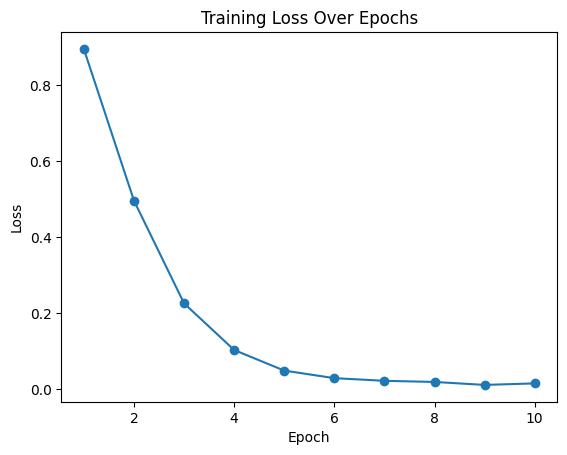

In [52]:
# Tracé de la loss au cours des epochs
plt.plot(range(1, n_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

Pour améliorer la performance de l'entrainement, améliorons le padding sur le champ réceptif - afin d'agrandir le champ sans décimer le signal.

In [53]:
class ImprovedCNNModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1, #same padding
                               dilation=2, # paramètre de dilatation
                               ) 
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1, #same padding
                               dilation=2, # paramètre de dilatation pour augmenter le champ perceptif
                               ) 
        self.fc1 = nn.Linear(65408, 128) 
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

#Paramètres du problème (reste fixé)

model2 = ImprovedCNNModel(input_channels, num_classes)
print(model2)

print("ImprovedCNNModel nombre de paramètres:", count_n_param(model2))


ImprovedCNNModel(
  (conv1): Conv1d(2, 16, kernel_size=(3,), stride=(1,), padding=(1,), dilation=(2,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,), dilation=(2,))
  (fc1): Linear(in_features=65408, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)
ImprovedCNNModel nombre de paramètres: 8374806


In [54]:
loss = nn.NLLLoss()

optimizer = torch.optim.Adam(model2.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = 10 # le nombre d'itérations dans l'entrainement 

dataset = MyDataset(data_path)

dataloader_train = DataLoader(dataset,
                                batch_size=32,
                                shuffle=True
                                 )


chemin_vers_sauvegarde_model2 = 'model2.pth'

model = model2
model2.to(device) # on place le modèle dans le GPU

train_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0  # Initialize epoch_loss at the beginning of each epoch
    
    for batch_x,batch_y in dataloader_train:
        batch_x = batch_x.permute(0, 2, 1).to(device)
        batch_y = batch_y.to(device).long() 
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
                
        optimizer.step()

        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
        
        epoch_loss += l.item()

    avg_epoch_loss = epoch_loss / len(dataloader_train)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_epoch_loss:.4f}')
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model2, chemin_vers_sauvegarde_model2)

Epoch 1/10, Loss: 1.1810
Epoch 2/10, Loss: 0.7159
Epoch 3/10, Loss: 0.3373
Epoch 4/10, Loss: 0.1684
Epoch 5/10, Loss: 0.0755
Epoch 6/10, Loss: 0.0354
Epoch 7/10, Loss: 0.0300
Epoch 8/10, Loss: 0.0147
Epoch 9/10, Loss: 0.0146
Epoch 10/10, Loss: 0.0163


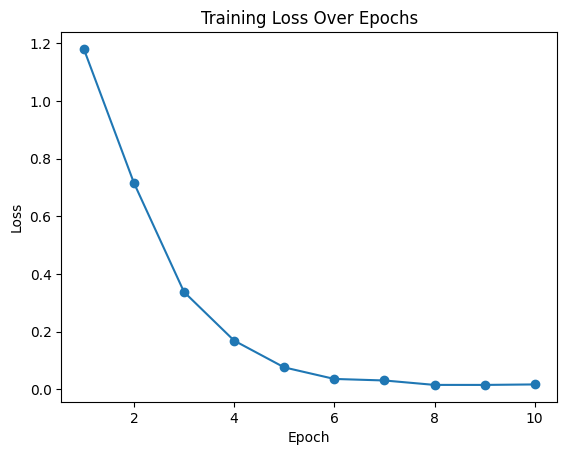

In [55]:
# Tracé de la loss au cours des epochs
plt.plot(range(1, n_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

Essayons d'améliorer avec d'autres paramètres de dilation et de stride.

In [56]:
class ImprovedCNNModel2(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ImprovedCNNModel2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1, #same padding
                               dilation=2, # paramètre de dilatation
                               ) 
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1, #same padding
                               stride=2, # paramètre de stride pour décimer le signal
                               ) 
        self.fc1 = nn.Linear(32736, 128) 
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

#Paramètres du problème (reste fixé)

model3 = ImprovedCNNModel2(input_channels, num_classes)
print(model3)

print("ImprovedCNNModel nombre de paramètres:", count_n_param(model2))


ImprovedCNNModel2(
  (conv1): Conv1d(2, 16, kernel_size=(3,), stride=(1,), padding=(1,), dilation=(2,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
  (fc1): Linear(in_features=32736, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)
ImprovedCNNModel nombre de paramètres: 8374806


In [57]:
loss = nn.NLLLoss()

optimizer = torch.optim.Adam(model3.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = 10 # le nombre d'itérations dans l'entrainement 

dataset = MyDataset(data_path)

dataloader_train = DataLoader(dataset,
                                batch_size=32,
                                shuffle=True
                                 )


chemin_vers_sauvegarde_model3 = 'model3.pth'

model = model3
model3.to(device) # on place le modèle dans le GPU

train_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0  # Initialize epoch_loss at the beginning of each epoch
    
    for batch_x,batch_y in dataloader_train:
        batch_x = batch_x.permute(0, 2, 1).to(device)
        batch_y = batch_y.to(device).long() 
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
                
        optimizer.step()

        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
        
        epoch_loss += l.item()

    avg_epoch_loss = epoch_loss / len(dataloader_train)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_epoch_loss:.4f}')
            
        # loggez la loss et les métriques sur le batch de validation
torch.save(model3, chemin_vers_sauvegarde_model3)

Epoch 1/10, Loss: 1.1638
Epoch 2/10, Loss: 1.0801
Epoch 3/10, Loss: 0.7596
Epoch 4/10, Loss: 0.3028
Epoch 5/10, Loss: 0.1636
Epoch 6/10, Loss: 0.0728
Epoch 7/10, Loss: 0.0344
Epoch 8/10, Loss: 0.0304
Epoch 9/10, Loss: 0.0226
Epoch 10/10, Loss: 0.0174


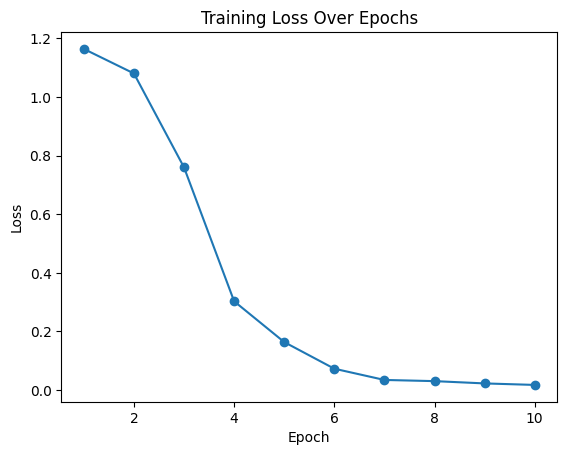

In [58]:
torch.save(model1, chemin_vers_sauvegarde_model1)
# Tracé de la loss au cours des epochs
plt.plot(range(1, n_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

Prenons le meilleur de ces trois modèles et augmentons la taille du kernel

In [61]:
class ImprovedCNNModel_kernel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ImprovedCNNModel_kernel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=11, padding=1, #same padding
                               dilation=2, # paramètre de dilatation
                               ) 
        self.conv2 = nn.Conv1d(16, 32, kernel_size=11, padding=1, #same padding
                               dilation=2, # paramètre de dilatation pour augmenter le champ perceptif
                               ) 
        self.fc1 = nn.Linear(64384, 128) 
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

#Paramètres du problème (reste fixé)

model4 = ImprovedCNNModel_kernel(input_channels, num_classes)
print(model4)

print("ImprovedCNNModel nombre de paramètres:", count_n_param(model2))


ImprovedCNNModel_kernel(
  (conv1): Conv1d(2, 16, kernel_size=(11,), stride=(1,), padding=(1,), dilation=(2,))
  (conv2): Conv1d(16, 32, kernel_size=(11,), stride=(1,), padding=(1,), dilation=(2,))
  (fc1): Linear(in_features=64384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)
ImprovedCNNModel nombre de paramètres: 8374806


In [62]:
loss = nn.NLLLoss()

optimizer = torch.optim.Adam(model4.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = 10 # le nombre d'itérations dans l'entrainement 

dataset = MyDataset(data_path)

dataloader_train = DataLoader(dataset,
                                batch_size=32,
                                shuffle=True
                                 )


chemin_vers_sauvegarde_model4= 'model4.pth'

model = model4
model4.to(device) # on place le modèle dans le GPU

train_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0  # Initialize epoch_loss at the beginning of each epoch
    
    for batch_x,batch_y in dataloader_train:
        batch_x = batch_x.permute(0, 2, 1).to(device)
        batch_y = batch_y.to(device).long() 
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
                
        optimizer.step()

        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
        
        epoch_loss += l.item()

    avg_epoch_loss = epoch_loss / len(dataloader_train)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_epoch_loss:.4f}')
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model4, chemin_vers_sauvegarde_model4)

Epoch 1/10, Loss: 1.2231
Epoch 2/10, Loss: 1.0905
Epoch 3/10, Loss: 0.9718
Epoch 4/10, Loss: 0.5345
Epoch 5/10, Loss: 0.1233
Epoch 6/10, Loss: 0.0243
Epoch 7/10, Loss: 0.0214
Epoch 8/10, Loss: 0.0347
Epoch 9/10, Loss: 0.0355
Epoch 10/10, Loss: 0.0201


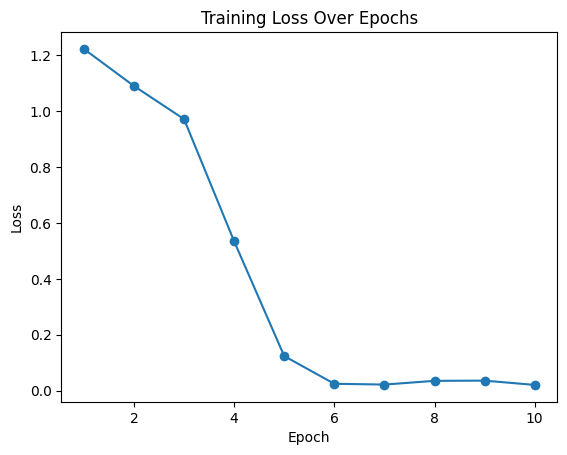

In [63]:
torch.save(model1, chemin_vers_sauvegarde_model1)
# Tracé de la loss au cours des epochs
plt.plot(range(1, n_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

Augmenter le nombre de Kernel ne semble pas améliorer l'entrainement du modèle.

### Avec un réseau convolutionel LSTM

In [64]:
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN_LSTM_Model, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding="same")
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding="same")
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, batch_first=True)
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, sequence_length, input_size)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the output of the last time step
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Paramètres du problème (reste fixé)
input_channels = 2  # Number of channels in the input signal
num_classes = 6     # Number of classes to identify

cnn_lstm_model = CNN_LSTM_Model(input_channels, num_classes)
print(cnn_lstm_model)

print("LSTM_CNN_Model nombre de paramètres:", count_n_param(cnn_lstm_model))

CNN_LSTM_Model(
  (conv1): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=same)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=same)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
LSTM_CNN_Model nombre de paramètres: 238630


In [66]:
# Initialisation du modèle
model = cnn_lstm_model
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

chemin_vers_sauvegarde_modelLSTM = 'modelCNNLSTM.pth'


# Paramètres d'entrainement
n_epochs = 10
train_losses = []


model = cnn_lstm_model
model.to(device)  #Placer le modèle sur le GPU si possible

# Boucle d'entraînement
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in dataloader_train:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        batch_x = batch_x.permute(0, 2, 1).to(device)
        batch_y = batch_y.to(device).long()

        
        optimizer.zero_grad()
        batch_y_predicted = model(batch_x)
        loss = loss_fn(batch_y_predicted, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(dataloader_train)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_epoch_loss:.4f}')

torch.save(model, chemin_vers_sauvegarde_modelLSTM)

Epoch 1/10, Loss: 0.7095
Epoch 2/10, Loss: 0.6636
Epoch 3/10, Loss: 0.6592
Epoch 4/10, Loss: 0.6369
Epoch 5/10, Loss: 0.6417
Epoch 6/10, Loss: 0.6362
Epoch 7/10, Loss: 0.6356
Epoch 8/10, Loss: 0.6310
Epoch 9/10, Loss: 0.6566
Epoch 10/10, Loss: 0.6260


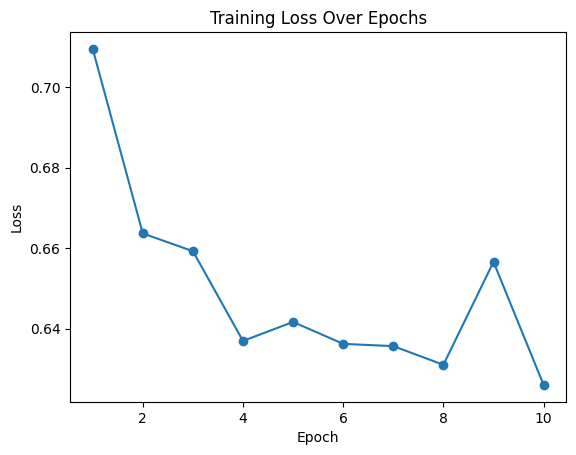

In [67]:
# Tracé de la loss au cours des epochs
plt.plot(range(1, n_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

Visiblement, l'apprentissage est sensiblement moins efficace avec cette méthode.

### Mise en place de l'augmentation de données

In [80]:
def augment_data(signal, snr):
    signal = torch.from_numpy(signal)  # Convert numpy array to tensor
    noise = torch.randn_like(signal) * (10 ** (-snr / 20))
    augmented_signal = signal + noise
    return augmented_signal

def custom_collate_fn(batch):
    signals, labels, snrs = zip(*batch)
    augmented_signals = []
    for signal, snr in zip(signals, snrs):
        augmented_signal = augment_data(signal, snr)
        augmented_signals.append(augmented_signal)
    return torch.stack(augmented_signals), torch.tensor(labels)

dataset = MyDataset(data_path)

dataloader_augmented = DataLoader(dataset, 
                                  batch_size=batch_size, 
                                  shuffle=True, 
                                  collate_fn=custom_collate_fn)


#### Test avec le meilleur modèle testé précdemment (modèle 3 - avec deux extensions de données)

In [84]:
loss = nn.NLLLoss()
     # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model3.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = 25 # le nombre d'itérations dans l'entrainement - que nous augmentons pour tenir compte de l'augmentation de données

chemin_vers_sauvegarde_model3_augmented = 'model3_augmented.pth'

model = model3
model3.to(device) # on place le modèle dans le GPU si nécessaire

train_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0  # Initialize epoch_loss at the beginning of each epoch
    
    for batch_x,batch_y in dataloader_augmented:
        batch_x = batch_x.permute(0, 2, 1).to(device)
        batch_y = batch_y.to(device).long()
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
    
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
        
        epoch_loss += l.item()

    avg_epoch_loss = epoch_loss / len(dataloader_augmented)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_epoch_loss:.4f}')
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model3, chemin_vers_sauvegarde_model3_augmented)

Epoch 1/25, Loss: 0.0604
Epoch 2/25, Loss: 0.0476
Epoch 3/25, Loss: 0.0449
Epoch 4/25, Loss: 0.0459
Epoch 5/25, Loss: 0.0437
Epoch 6/25, Loss: 0.0484
Epoch 7/25, Loss: 0.0408
Epoch 8/25, Loss: 0.0479
Epoch 9/25, Loss: 0.0446
Epoch 10/25, Loss: 0.0426
Epoch 11/25, Loss: 0.0382
Epoch 12/25, Loss: 0.0349
Epoch 13/25, Loss: 0.0354
Epoch 14/25, Loss: 0.0387
Epoch 15/25, Loss: 0.0345
Epoch 16/25, Loss: 0.0346
Epoch 17/25, Loss: 0.0345
Epoch 18/25, Loss: 0.0330
Epoch 19/25, Loss: 0.0325
Epoch 20/25, Loss: 0.0296
Epoch 21/25, Loss: 0.0302
Epoch 22/25, Loss: 0.0315
Epoch 23/25, Loss: 0.0300
Epoch 24/25, Loss: 0.0292
Epoch 25/25, Loss: 0.0262


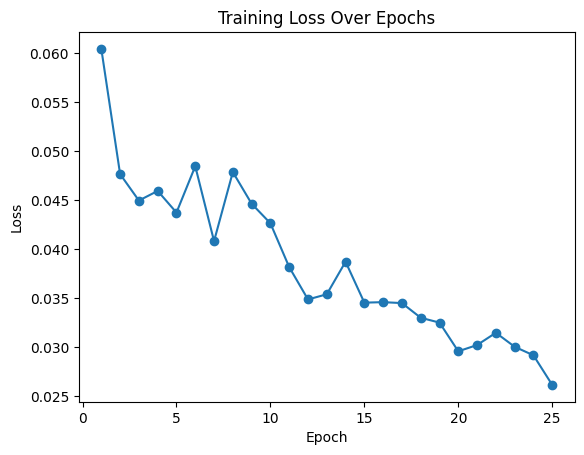

In [85]:
# Tracé de la loss au cours des epochs
plt.plot(range(1, n_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

L'augmentation des données, si elle n'améliore pas l'entrainement permettra d'éviter les overfittings en étant plus robuste au bruit.

## Synthèse des résultats
Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test sans oublier de mesurer également la complexité de chaque approche en termes de nombre de paramètres. Si vous avez testé des approches qui vous semblent avoir échoué vous pouvez rédiger un petit paragraphe pour expliquer votre analyse de cet échec. 

In [102]:
# Load the test dataset
test_dataset = MyDataset('test.hdf5')
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the trained models
model0 = torch.load(chemin_vers_sauvegarde_model0)
model1 = torch.load(chemin_vers_sauvegarde_model1)
model2 = torch.load(chemin_vers_sauvegarde_model2)
model3 = torch.load(chemin_vers_sauvegarde_model3)
model4 = torch.load(chemin_vers_sauvegarde_model4)
model_lstm = torch.load(chemin_vers_sauvegarde_modelLSTM)
model3_augmented = torch.load(chemin_vers_sauvegarde_model3_augmented)

# Set the models to evaluation mode
model0.eval()
model1.eval()
model2.eval()
model3.eval()
model4.eval()
model_lstm.eval()
model3_augmented.eval()

# Move models to the appropriate device
model0.to(device)
model1.to(device)
model2.to(device)
model3.to(device)
model4.to(device)
model_lstm.to(device)
model3_augmented.to(device)

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels_model0 = []
predicted_labels_model1 = []
predicted_labels_model2 = []
predicted_labels_model3 = []
predicted_labels_model4 = []
predicted_labels_modelLSTM = []
predicted_labels_model3_augmented = []

# Initialiser les métriques de précision
accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)

accuracies = {
    "model0": [],
    "model1": [],
    "model2": [],
    "model3": [],
    "model4": [],
    "modelLSTM": [],
    "model3_augmented": []
}
snrs = [] 

# Evaluation des modèles
for snr in snrs:
    true_labels_snr = []
    predicted_labels_snr = {model: [] for model in accuracies.keys()}
    
    with torch.no_grad():
        for batch_x, batch_y in test_dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Collect true labels
            true_labels_snr.extend(batch_y.cpu().numpy())
            
            # Evaluate each model
            for model_name, model in zip(accuracies.keys(), 
                                         [model0, model1, model2, model3, model4, model_lstm, model3_augmented]):
                outputs = model(batch_x)
                _, predicted = torch.max(outputs, 1)
                predicted_labels_snr[model_name].extend(predicted.cpu().numpy())

        # Calculate accuracy for each model at the current SNR
        for model_name in accuracies.keys():
            acc = accuracy_metric(torch.tensor(predicted_labels_snr[model_name]), 
                                  torch.tensor(true_labels_snr))
            accuracies[model_name].append(acc.item())


accuracy_model0 = accuracy_score(true_labels, predicted_labels_model0)
accuracy_model1 = accuracy_score(true_labels, predicted_labels_model1)
accuracy_model2 = accuracy_score(true_labels, predicted_labels_model2)
accuracy_model3 = accuracy_score(true_labels, predicted_labels_model3)
accuracy_model4 = accuracy_score(true_labels, predicted_labels_model4)
accuracy_modelLSTM = accuracy_score(true_labels, predicted_labels_modelLSTM)
accuracy_model3_augmented = accuracy_score(true_labels, predicted_labels_model3_augmented)

# Calcul des matrices de confusion
for snr in snrs:
    true_labels_snr = []
    predicted_labels_snr = {model: [] for model in accuracies.keys()}

    # Filtrer les données pour le SNR actuel
    with torch.no_grad():
        for batch_x, batch_y in test_dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            true_labels_snr.extend(batch_y.cpu().numpy())
            for model_name, model in zip(predicted_labels_snr.keys(), 
                                         [model0, model1, model2, model3, model4, model_lstm, model3_augmented]):
                outputs = model(batch_x)
                _, predicted = torch.max(outputs, 1)
                predicted_labels_snr[model_name].extend(predicted.cpu().numpy())
    
    # Plot confusion matrix for each model
    for model_name in predicted_labels_snr.keys():
        cm = confusion_matrix(true_labels_snr, predicted_labels_snr[model_name])
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix for {model_name} at SNR {snr} dB")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()

# Print results
print(f"Model0 Accuracy: {accuracy_model0:.4f}")
print(f"Model1 Accuracy: {accuracy_model1:.4f}")
print(f"Model2 Accuracy: {accuracy_model2:.4f}")
print(f"Model3 Accuracy: {accuracy_model3:.4f}")
print(f"Model4 Accuracy: {accuracy_model4:.4f}")
print(f"ModelLSTM Accuracy: {accuracy_modelLSTM:.4f}")
print(f"Model3 Augmented Accuracy: {accuracy_model3_augmented:.4f}")
print("Model0 Confusion Matrix:")
print(confusion_matrix_model0)
print("Model1 Confusion Matrix:")
print(confusion_matrix_model1)
print("Model2 Confusion Matrix:")
print(confusion_matrix_model2)
print("Model3 Confusion Matrix:")
print(confusion_matrix_model3)
print("Model4 Confusion Matrix:")
print(confusion_matrix_model4)
print("ModelLSTM Confusion Matrix:")
print(confusion_matrix_modelLSTM)
print("Model3 Augmented Confusion Matrix:")
print(confusion_matrix_model3_augmented)

# Measure model complexity
num_params_model0 = count_n_param(model0)
num_params_model1 = count_n_param(model1)
num_params_model2 = count_n_param(model2)
num_params_model3 = count_n_param(model3)
num_params_model4 = count_n_param(model4)
num_params_modelLSTM = count_n_param(model_lstm)
num_params_model3_augmented = count_n_param(model3_augmented)
print(f"Model0 Number of Parameters: {num_params_model0}")
print(f"Model1 Number of Parameters: {num_params_model1}")
print(f"Model2 Number of Parameters: {num_params_model2}")
print(f"Model3 Number of Parameters: {num_params_model3}")
print(f"Model4 Number of Parameters: {num_params_model4}")
print(f"ModelLSTM Number of Parameters: {num_params_modelLSTM}")
print(f"Model3 Augmented Number of Parameters: {num_params_model3_augmented}")

Enregistrement de: training à la valeur False
Model0 Accuracy: nan
Model1 Accuracy: nan
Model2 Accuracy: nan
Model3 Accuracy: nan
Model4 Accuracy: nan
ModelLSTM Accuracy: nan
Model3 Augmented Accuracy: nan
Model0 Confusion Matrix:
[]
Model1 Confusion Matrix:
[]
Model2 Confusion Matrix:
[]
Model3 Confusion Matrix:
[]
Model4 Confusion Matrix:
[]
ModelLSTM Confusion Matrix:
[]
Model3 Augmented Confusion Matrix:
[]
Model0 Number of Parameters: 4
Model1 Number of Parameters: 8391190
Model2 Number of Parameters: 8374806
Model3 Number of Parameters: 4192790
Model4 Number of Parameters: 8248086
ModelLSTM Number of Parameters: 238630
Model3 Augmented Number of Parameters: 4192790


/home/cvaillanttenzer/.conda/envs/torch_env/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/cvaillanttenzer/.conda/envs/torch_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/cvaillanttenzer/.conda/envs/torch_env/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/cvaillanttenzer/.conda/envs/torch_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/cvaillanttenzer/.conda/envs/torch_env/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/cvaillanttenzer/.conda/envs/torch_env/lib/python3.10/site-packages

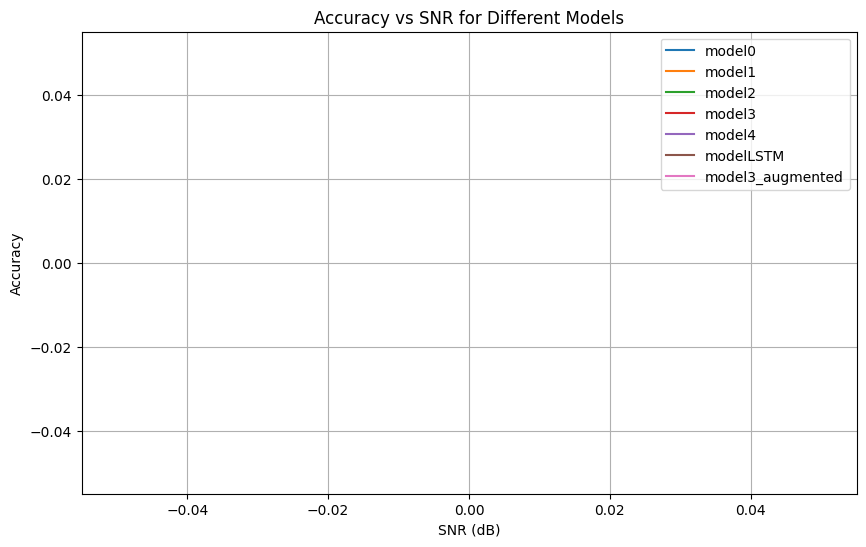

In [103]:
plt.figure(figsize=(10, 6))
for model_name, model_accuracies in accuracies.items():
    plt.plot(snrs, model_accuracies, label=model_name)
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs SNR for Different Models")
plt.legend()
plt.grid()
plt.show()

Comparaison de la complexité des modèles

In [100]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

complexities = {
    "Model0": count_parameters(model0),
    "Model1": count_parameters(model1),
    "Model2": count_parameters(model2),
    "Model3": count_parameters(model3),
    "Model4": count_parameters(model4),
    "ModelLSTM": count_parameters(model_lstm),
    "Model3 Augmented": count_parameters(model3_augmented)
}

print("Model Complexities:")
for model_name, num_params in complexities.items():
    print(f"{model_name}: {num_params} parameters")

Model Complexities:
Model0: 4 parameters
Model1: 8391190 parameters
Model2: 8374806 parameters
Model3: 4192790 parameters
Model4: 8248086 parameters
ModelLSTM: 238630 parameters
Model3 Augmented: 4192790 parameters


## Conclusion

%TODO

## Reste à faire

- Faire de l'hyperparameter tuning
- Réentrainer les modèles avec de l'augmentation de données
- Compléter/rédiger la synthèse
- Améliorer la présentation du notebook et du rapport
- Tracer graphs analyse signal au début
- Padding sur le champ réceptif ( padding = "same"     
        #stride=2, # T’ = T//2
        #dilation=2, # paramètre de dilatation)
- Parralélisation avec JAX

### Optional
- Eventuellement tester d'autres modèles (pourquoi pas un transformer)